# AdaBoost

Based on **Patric Loeber** video: https://www.youtube.com/watch?v=wF5t4Mmv5us&list=PLqnslRFeH2Upcrywf-u2etjdxxkL8nl7E&index=13

Adaboost uses the boosting approach which follows the simple idea to combine multiple weak classifier into one strong  classifier and this approach works really well in practice.

## Concept 

We have our samples with only two different features on the x axis and on the y axis. The first classifier makes a split based on the y axis in this example so it draws a horizontal decision line at some threshold so the dashed line we can see here and we can see that some predictions are correct but we also have missclassifications. With these misclassifications we can then calculate a preformance measure so the accuracy for this classifier and with this measure we calculate and update weights for all training samples. The second classifier comes in and it useses these weights and finds a different and possibly better decision boundary so the second classifier in this example chooses a feature on the x asix and draws a vertical line. Then again we calculate the preformance and update th weights. Then we repeat this step for as many classifiers as we want. Then at the very end we have all the different decision lines and we also have all the different classifier performances. Then we combine all our classifiers so we can make a weighted sum with the calculated performances. This allows us to draw the perfect decision line that we can see here which can be more complex than a simple linear decision line. The better the classifier is the more impact it has for the finall outcome.

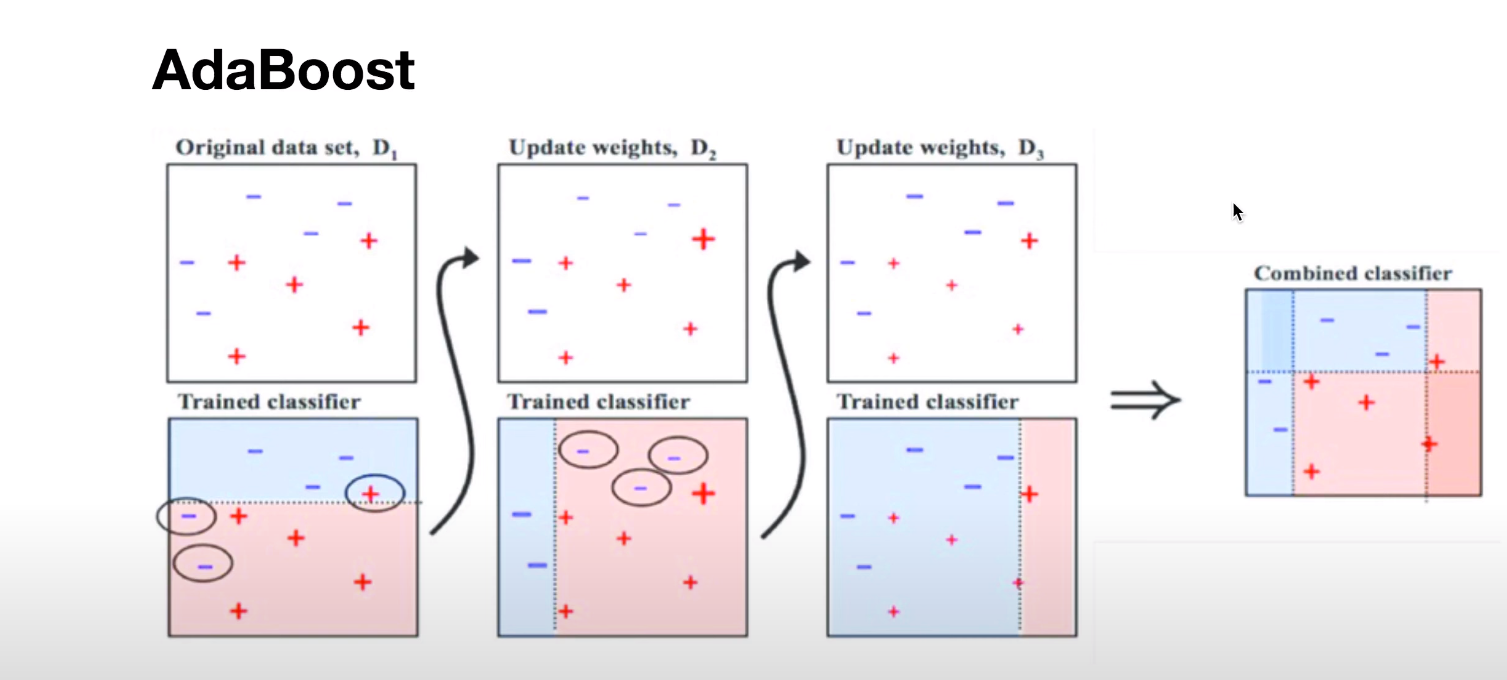

## Weak Learner (Decision Stump)

First thing that we need is a weak classifier and this is also called weak learner. A weak learner is always a very simple classifier and in the case of the adaboost we use a so called decision stamp for this so a decision stump is basically a decision tree with only one split. We look at only one feature of our samples and only at one threshold. Then based on if our feature value is greater or smaller than the threshold we say that it is class minus 1 or class plus 1.

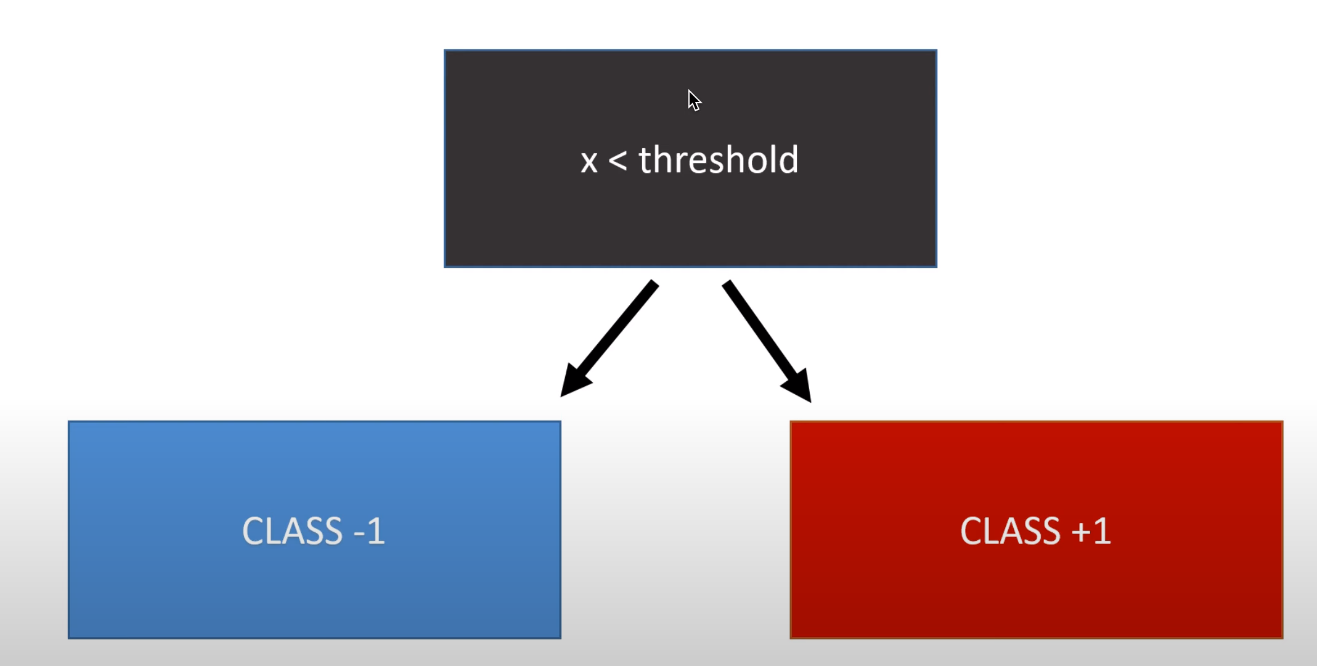

## Error

### $ \varepsilon_{t} = \frac{missclassifications}{samples} = \frac{missclassifications}{N} $ (in the first iteration)

### $ \varepsilon_{t} = \sum_{miss} weights $

If error > 0.5, just flip the decision and the error = 1 - error.

### Notes

The first time douring our iteration the error is calculated as the number of misclassifications divided by the total number of samples and this is the natural approach of the error. If we have look at our example again we cann see that we have 10 samples in this case and in the first classifier we have 3 misclassifications so this means that our error rate is 0.3. This is the first time but the next time we also want to take into account the weights so if a sample was misclassified we give it a higher weight for the next iteration. This means that our formula is then calculated as the sum over the weights for all misclassifications and if our error is greater than 0.5 we simply flip all decisions and we also flip our error so it is then 1 minus the error.

## Weights

### $ w_{0} = \frac{1}{N} $ for each sample

### $ w = \frac{w\cdot exp(-\alpha \cdot y \cdot h(X))}{sum(w)} $, where $h(X) =$ prediction of t

### Notes

The weights are initially set to 1 over N for each sample and this also matches the error calculation in the first step. If we say we calculate the error as the sum over all missclassified weights and we also say that each weight is 1 over N in the beginning then it is equal to the number of misclassifications divided by the number of samples. That's why the initial weights are 1 over N for each sample. Then we also need the update rule that is definded as old weights times the xponential function of -alpha times the actual y times h of X where h of X is our prediction and alpha is the acuracy of the classifier so if this is munus 1 we have a miss classification and if this is plus 1 then we have a correct classification. This whole formula basically makes sure that classic misclassified samples have a higher impact for the next classifier so this is what we should remember from the weights.

## Performance

### $ \alpha = 0.5 \cdot \log(\frac{1-\varepsilon_{t}}{\varepsilon_{t}}) $

### Notes

We need to calculate the performance which is alpha for each classifier and we need this for the final prediciton. The formula for the performance is calculated as 0.5 times the log of 1 minus the error divided by the error. Our error is always between 0 and 1.

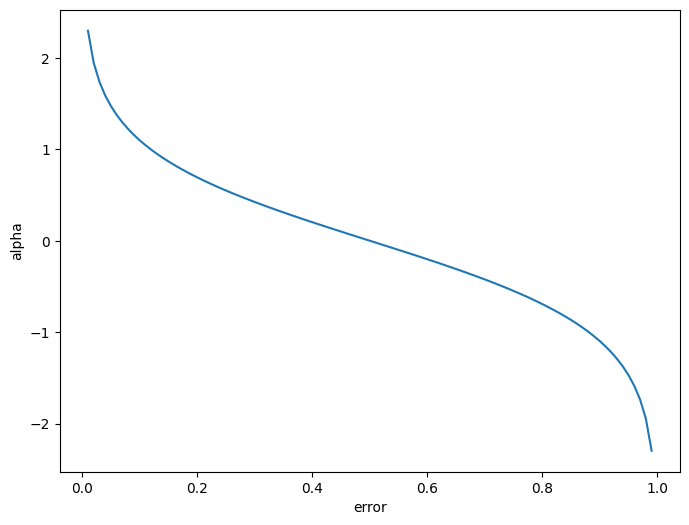

In [1]:
import numpy as np
import matplotlib.pyplot as plt
alpha = lambda x: 0.5 * np.log((1.0 - x) / x)
error = np.arange(0.01, 1.00, 0.01)

plt.figure(figsize=(8,6))
plt.xlabel('error')
plt.ylabel('alpha')
plt.plot(error, alpha(error))
plt.show()

### Notes

If we plot alpha for different errors in this range, we can see that it is equaly distributed somewhere between a positive value and a negative value. So with a low error we have a high positive value and with a high error close to 1 we have a high negative value but since we are flipping the decision then this will be correct classifications again with a high contribution to the negative side.

## Prediction

### $ y = sign(\sum_{t}^{T} \alpha_{t} \cdot h(X)) $

### Notes

The final prediction is very easy to understand, we just choose the sign of the sum over all predictions. We weight each prediction with the performance of the classifier so alpha times the prediction. So the better our classifier the more impact it has for the final prediction and the better the classifier the more it points into the negative or positive side. Then we take the better side as prediction for our class. That is the concept of the prediction.

## Training

Initialize weights for each sample = 1/N

for t in T:
+ Train week classifier (greedy search to find best feature and threshold)
+ Calculate error $ \varepsilon_{t} = \sum_{miss}weights $
    + flip error and decision if error > 0.5
+ Calculate $ \alpha = 0.5 \cdot \log(\frac{1-\varepsilon_{t}}{\varepsilon_{t}}) $
+ Update weights: $ w = \frac{w \cdot exp(-\alpha \cdot h(X))}{sum(w)} $

### Notes

We specify the number of t which are weak classifiers.

In [6]:
import numpy as np

class DecisionStump:
    
    def __init__(self):
        # polarity tells us if the sample should be classified as -1 or 1 for the given threshold
        # if we want to flip the error we also must flip the polarity
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None
        
    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1
        return predictions
    
class Adaboost:
    
    def __init__(self, n_clf=5):
        self.n_clf = n_clf
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # init weights
        w = np.full(n_samples, (1/n_samples))
        
        # iteration through all the classifiers
        # list where we store all the classifiers
        self.clfs = []
        for _ in range(self.n_clf):
            # we want to do greedy search so we will iterate over all the features
            # and all the thresholds
            clf = DecisionStump()
            
            # we want to find the best split feature and split threshold where this error is minimum
            min_error = float('inf')
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)
                
                for threshold in thresholds:
                    # we want to predict with the polarity 1 first and then calculate the error
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = - 1
                    
                    missclasified = w[y != predictions]
                    error = sum(missclasified)
                    
                    if error > 0.5:
                        error = 1 - error
                        p = -1
                        
                    if error < min_error:
                        min_error = error
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
            
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1-error) / (error + EPS))
            
            
            predictions = clf.predict(X)
            
            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)
            
            self.clfs.append(clf)
            
    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)
        return y_pred

In [8]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split 
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

data = datasets.load_breast_cancer()
X = data.data
y = data.target

# we have to set all the labels that are 0 to minus 1 because adaboost needs the labels as -1 and 1
y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Adaboost classification with 5 weak classifiers

clf = Adaboost(n_clf=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9473684210526315
